<a href="https://colab.research.google.com/github/kishoret04/statisticallearning_datamining/blob/kishoret04-patch-1/DIgit_recognizer_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import pandas as pd
import numpy as np
from scipy import io
import math
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib.colors import Normalize

from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from pandas import ExcelWriter


In [0]:
!pip install -q xlrd
!git clone https://github.com/kishoret04/statisticallearning_datamining.git
##Files from the cloned git repository.
!ls  statisticallearning_datamining/datasets

Cloning into 'statisticallearning_datamining'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), done.
HW4part2_DS.xlsx  sample


# Functions

In [0]:
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

#show size of dataset, each class and plot histogram of mean standard deviations
def dataset_describe(dataset_nolabel,dataset_labels):
  #class values
  class_1 = 7
  class_2 = 8
  class_3 = 9
  print('Name of class 1:{0}\tSize of class 1:{1}'.format(class_1,sum(dataset_labels == class_1)))
  print('Name of class 2:{0}\tSize of class 2:{1}'.format(class_2,sum(dataset_labels == class_2)))
  print('Name of class 3:{0}\tSize of class 3:{1}'.format(class_3,sum(dataset_labels == class_3)))
  print('\tSize of dataset:{0}'.format(dataset_nolabel.shape[0]))
  print('number of features in dataset: ',dataset_nolabel.shape[1])
  
  # hist of original data
  plt.hist(dataset_nolabel.mean())
  plt.title('Dataset mean')
  plt.xlabel("mean")
  plt.ylabel("frequency");
  plt.show()

  plt.hist(dataset_nolabel.std())
  plt.title('Dataset Standard deviation')
  plt.xlabel("Standard deviation")
  plt.ylabel("frequency");
  plt.show()

  plt.scatter(dataset_nolabel.mean(),dataset_nolabel.std(),marker = '.')
  plt.title('Scatter plot of mean and SD')
  plt.xlabel("Mean")
  plt.ylabel("Standard Deviation");
  plt.show()

#function to remove null columns
def remove_zerocolumns(df_input ):    
  df_residual_data = df_input.loc[:,df_input.sum(axis=0) != 0]
  return df_residual_data

# def standardize_dataset(df_residual_data):
#   #standardizing data
#   #df_totaldata_nolabel = self.df_residual_data.drop(columns='label')
#   df_totaldata_nolabel = df_residual_data.drop(columns='label')
#   df_std_data = (df_totaldata_nolabel - df_totaldata_nolabel.mean())/df_totaldata_nolabel.std()
#   df_std_data['label'] = df_totaldata['label']
#   return df_std_data

def create_traintestdata(prop,df_std_data):
  class_1 = 7
  class_2 = 8
  class_3 = 9
  #dividing into 3 classes
  df_class1 = df_std_data[df_std_data['label'] == class_1]
  df_class2 = df_std_data[df_std_data['label'] == class_2]
  df_class3 = df_std_data[df_std_data['label'] == class_3]

  #calculate trainset size for cl1
  train_size = int(prop*df_class1.shape[0]/100)    
  #extract a random sample of 80% CL1 as train and 20% CL1 as test set
  train_data = df_class1.sample(train_size)
  test_data = df_class1.drop(train_data.index)
  
  #calculate trainset size for cl2
  train_size = int(prop*df_class2.shape[0]/100)
  #extract a random sample of 80% CL2 as train and 20% CL2 as test set
  cl2_train = df_class2.sample(train_size)
  cl2_test = df_class2.drop(cl2_train.index)

  #calculate trainset size for cl3
  train_size = int(prop*df_class3.shape[0]/100)
  #extract a random sample of 80% CL2 as train and 20% CL2 as test set
  cl3_train = df_class3.sample(train_size)
  cl3_test = df_class3.drop(cl3_train.index)

  #creating train and test sets by combinining all three classes
  train_data = train_data.append(cl2_train,ignore_index = True)
  train_data = train_data.append(cl3_train,ignore_index = True)

  test_data = test_data.append(cl2_test,ignore_index = True)
  test_data = test_data.append(cl3_test,ignore_index = True)

  #separating class labels from train and test
  train_data_nolabel = train_data.drop(columns = ['label'])
  train_labels_all = train_data['label']

  test_data_nolabel = test_data.drop(columns = ['label'])
  test_labels_all = test_data['label']

  return train_data,test_data,train_data_nolabel,train_labels_all,test_data_nolabel,test_labels_all

def create_twoclass_dataset(train_data_nolabel,train_labels_all,class1,class2):
  #choosing classes for train
  print('creating dataset with 2 given classes:{0},{1} '.format(class1,class2))
  train_data = train_data_nolabel[train_labels_all == class1]
  print('train_data size1: ',train_data.shape[0])
  df_class2 = train_data_nolabel[train_labels_all == class2]
  train_data = train_data.append(df_class2,ignore_index = True)
  print('train_data size total: ',train_data.shape[0])

  #train_labels = train_labels_all[train_labels_all ==class1]
  #df_class2_labels = train_labels_all[train_labels_all ==class2]
  train_labels = pd.Series(1*np.ones(sum(train_labels_all == class1)))
  print('train_labels_1 class:\n',train_labels.size)
  df_class2_labels = pd.Series(-1*np.ones(sum(train_labels_all == class2)))

  train_labels = train_labels.append(df_class2_labels,ignore_index = True)
  print('self.train_labels total:\n',train_labels.size)

  return train_data,train_labels


#function to create required class cl_r and not cl_r datasets and labels
def create_data_cl_r(class_r,data_nolabel,data_labels_all,do_reduce):

  #trainset creation for cl_req vs notcl_req
  #choosing classes for train
  train_data = data_nolabel[data_labels_all == class_r]
  print('data size1: ',train_data.shape[0])
  train_labels = pd.Series(1*np.ones(sum(data_labels_all == class_r)))
  print('data_labels_1 class:\n',train_labels.size)

  #sample class_r size from remaining classes
  df_class_notr = data_nolabel[data_labels_all  != class_r]
  df_class_notr_size = df_class_notr.shape[0]
  #print('df_class_notr_size: ',df_class_notr_size)
  #reduce class_notr size if required
  if do_reduce:

    size_sample = int((train_data.shape[0])/2)
    print('size_sample: ',size_sample)
    if class_r == 7:
      df_class_a = data_nolabel[data_labels_all == 8].sample(size_sample)
      df_class_b = data_nolabel[data_labels_all == 9].sample(size_sample)
    elif class_r == 8:
      df_class_a = data_nolabel[data_labels_all == 7].sample(size_sample)
      df_class_b = data_nolabel[data_labels_all == 9].sample(size_sample)
    elif class_r == 9:
      df_class_a = data_nolabel[data_labels_all == 7].sample(size_sample)
      df_class_b = data_nolabel[data_labels_all == 8].sample(size_sample)

    df_class_notr = df_class_a.append(df_class_b,ignore_index =True)
    df_class_notr_size = df_class_notr.shape[0]
    
  #print('df_class_notr_size:',df_class_notr_size)
  df_class_notr_labels = pd.Series(-1*np.ones(df_class_notr_size))
  train_data = train_data.append(df_class_notr,ignore_index = True)
  print('data size total: ',train_data.shape[0])

  train_labels = train_labels.append(df_class_notr_labels,ignore_index = True)
  print('data_labels total:\n',train_labels.size)

  return train_data,train_labels 


#training and predicting SVM with required paraeters and test/train data
def svm_call(kernel_type,parameters,train_data,train_labels,test_data,test_labels):
  
  ##########choosing kernel based on type###########
  if kernel_type == 'linear':
    print('kernel_type: ',kernel_type)
    print('parameters: ',parameters)
    svm_master = SVC(kernel=kernel_type, C=parameters['C'])

  elif kernel_type == 'rbf':
    print('kernel_type: ',kernel_type)
    svm_master = SVC(kernel=kernel_type, gamma=parameters['gamma'], C=parameters['C'])

  elif kernel_type == 'poly':
    print('kernel_type: ',kernel_type)
    svm_master = SVC(kernel=kernel_type,degree = parameters['degree'],coef0 = parameters['coef0'],
                     gamma = parameters['gamma'],C = parameters['C'])
  
  #######Train set fitted SVM######################
  #fitting train data into svm model   
  print('------Fitting train data into svm model-----')     
  svm_master.fit(train_data,train_labels)
  print('Score for above parameters in SVC model : ',
          svm_master.score(train_data,train_labels))
  pred_train_labels = svm_master.predict(train_data)
  size_data = train_data.shape[0]    
  
  #ROC plotting
  train_score = svm_master.fit(train_data, train_labels).decision_function(train_data)
  plot_roc(train_score,train_labels) 
 
  #sv count and ratio
  number_sv = sum(svm_master.n_support_)
  print('Number of Support vectors,S : ',number_sv)
  ratio_sv = round(number_sv/size_data,2)
  print('Ratio of Support vectors,s : ',ratio_sv) 
  ######updated confusion mat and error estimates#########################
  y_true = train_labels
  y_pred = svm_master.predict(train_data)

  cm,cm_norm = create_confusion_matrix(y_true, y_pred)
  cm_norm = np.around(cm_norm*100)
  df_cm = pd.DataFrame(cm,index = ['true_CL1','true_CL_1'],columns = ['pred_CL1','pred_CL_1'])
  df_cm_norm = pd.DataFrame(cm_norm,index = ['true_CL1','true_CL_1'],columns = ['pred_CL1','pred_CL_1'])
  print('confusion_matrix:\n',df_cm)
  print('confusion_matrix_norm:\n',df_cm_norm)
  df_confmat_train_error,df_confmat_train_confint = error_estimate_new(df_cm,df_cm_norm)
  
  print('\nconfmat_train_error:\n',df_confmat_train_error,
        '\nconfmat_train_confint:\n',df_confmat_train_confint)
  confmat_train_norm = df_cm_norm
  #####################################################################
  
  # ########SVM applied on test set############  
  
  print('------SVM applied on test set-----')    
  print('Score for above parameters in SVC model for testset : ',
        svm_master.score(test_data,test_labels))
  pred_test_labels = svm_master.predict(test_data)
  # #ROC plotting
  test_score = svm_master.fit(train_data, train_labels).decision_function(test_data)
  plot_roc(test_score,test_labels)
  # pred_train,pred_test = calc_correct_pred(svm_master,train_data,train_labels,test_data,test_labels)

  # print(pred_train['pred'])
  # print(pred_test['pred'])

  #confmat_train,confmat_test = calc_confusionmatrix(pred_train,pred_test)
  #write to excel
  filepath = 'SVM_output.xlsx'
  with ExcelWriter(filepath) as writer:
      pd.DataFrame(pred_train_labels).to_excel(writer,sheet_name = 'pred_train_labels' )
      pd.DataFrame(train_score).to_excel(writer,sheet_name = 'ROC_train_score' )
      pd.DataFrame(train_labels).to_excel(writer,sheet_name = 'ROC_train_labels' )
      pd.DataFrame(pred_test_labels).to_excel(writer,sheet_name = 'pred_test_labels' )
      pd.DataFrame(test_score).to_excel(writer,sheet_name = 'ROC_test_score' )
      pd.DataFrame(test_labels).to_excel(writer,sheet_name = 'ROC_test_labels' )
      writer.save()  
 ######updated confusion mat and error estimates#########################
  y_true = test_labels
  y_pred = svm_master.predict(test_data)

  cm,cm_norm = create_confusion_matrix(y_true, y_pred)
  cm_norm = np.around(cm_norm*100)
  df_cm = pd.DataFrame(cm,index = ['true_CL1','true_CL_1'],columns = ['pred_CL1','pred_CL_1'])
  df_cm_norm = pd.DataFrame(cm_norm,index = ['true_CL1','true_CL_1'],columns = ['pred_CL1','pred_CL_1'])
  print('confusion_matrix:\n',df_cm)
  print('confusion_matrix_norm:\n',df_cm_norm)
  df_confmat_test_error,df_confmat_test_confint = error_estimate_new(df_cm,df_cm_norm)
  
  print('\nconfmat_test_error:\n',df_confmat_test_error,
        '\nconfmat_test_confint:\n',df_confmat_test_confint)
  
  #####################################################################
  return svm_master,confmat_train_norm
    
def plot_roc(y_score,y_true):
  
  # print('y_score:\n', y_score)
  # print('y_true:\n', y_true)
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  # # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  #For CL1
  fpr[0], tpr[0], _ = roc_curve(y_true[y_score>0], y_score[y_score>0])
  roc_auc[0] = auc(fpr[0], tpr[0])
  #Plot of a ROC curve for a CL1
  plt.figure()
  lw = 2
  plt.plot(fpr[0], tpr[0], color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic CL1')
  plt.legend(loc="lower right")
  plt.show()

  #For CL_1
  fpr[1], tpr[1], _ = roc_curve(y_true[y_score<0], y_score[y_score<0])
  roc_auc[1] = auc(fpr[1], tpr[1])
  #Plot of a ROC curve for a CL1
  plt.figure()
  lw = 2
  plt.plot(fpr[1], tpr[1], color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic CL -1')
  plt.legend(loc="lower right")
  plt.show()

def calc_correct_pred(svm_master,train_data,train_labels,test_data,test_labels):
  
  #initializing pred_train and pred_test
  pred_train = pd.DataFrame(0,index =['total','cl1','cl_1'],
                                  columns = ['pred','error','conf_int'])
  pred_test = pd.DataFrame(0,index =['total','cl1','cl_1'],
                                  columns = ['pred','error','conf_int'])
  #calculating correct prediction for train data
  pred_train.loc['total','pred'] = svm_master.score(train_data,train_labels)*100
  
  #Prediction accuracy on train set for CL1 and CL_1
  pred_train.loc['cl1','pred'] = svm_master.score(train_data[train_labels > 0],
                                                  train_labels[train_labels > 0])*100

  pred_train.loc['cl_1','pred'] = svm_master.score(train_data[train_labels < 0],
                                                   train_labels[train_labels < 0])*100

  #calculating correct prediction for test data
  pred_test.loc['total','pred'] = svm_master.score(test_data,test_labels)*100
  
  #Prediction accuracy on test set for CL1 and CL_1           
  pred_test.loc['cl1','pred'] = svm_master.score(test_data[test_labels > 0],
                                                 test_labels[test_labels > 0])*100

  pred_test.loc['cl_1','pred'] = svm_master.score(test_data[test_labels < 0],
                                                  test_labels[test_labels < 0])*100

  return pred_train,pred_test

def calc_confusionmatrix(pred_train,pred_test):     

  confmat_train = pd.DataFrame(0,index = ['true_CL1','true_CL_1'],
                                      columns = ['pred_CL1','pred_CL_1'])
  confmat_test = pd.DataFrame(0,index = ['true_CL1','true_CL_1'],
                                      columns = ['pred_CL1','pred_CL_1'])
  #reading predictions for cl1 and cl_1
  pred_train_cl1 = pred_train.loc['cl1','pred']
  pred_train_cl_1 = pred_train.loc['cl_1','pred']

  #creating confusion matrix for train data
  confmat_train_data = np.array([pred_train_cl1,100-pred_train_cl1,100-pred_train_cl_1,pred_train_cl_1]).reshape(2,2)
  confmat_train = pd.DataFrame(np.around(confmat_train_data,2),index = ['true_CL1','true_CL_1'],columns = ['pred_CL1','pred_CL_1'])

  #reading predictions for cl1 and cl_1
  pred_test_cl1 = pred_test.loc['cl1','pred']
  pred_test_cl_1 = pred_test.loc['cl_1','pred']

  #creating confusion matrix for test data
  confmat_test_data = np.array([pred_test_cl1,100-pred_test_cl1,100-pred_test_cl_1,pred_test_cl_1]).reshape(2,2)
  confmat_test = pd.DataFrame(np.around(confmat_test_data,2),index = ['true_CL1','true_CL_1'],columns = ['pred_CL1','pred_CL_1'])

  return confmat_train,confmat_test

def error_estimate_new(confmat_train,confmat_train_norm): 
 
  confmat_train_error = np.zeros(confmat_train.shape)
  confmat_train_confint = np.chararray(confmat_train.shape,itemsize = 20)
  confmat_mat = np.mat(confmat_train)
  confmat_norm_mat = np.mat(confmat_train_norm)

  for i in range(confmat_mat.shape[0]):    
    size = np.sum(confmat_mat[i])
    for j in range(confmat_mat.shape[0]):      
      confmat_train_error[i][j] = err_est_element(confmat_norm_mat[i,j],size,True)
      confmat_train_confint[i][j] = err_est_element(confmat_norm_mat[i,j],size,False)      

  df_confmat_train_error =  pd.DataFrame(confmat_train_error,index = confmat_train.index,
                                    columns = confmat_train.columns)
  df_confmat_train_confint =  pd.DataFrame(confmat_train_confint,index = confmat_train.index,
                                    columns = confmat_train.columns)

  return df_confmat_train_error,df_confmat_train_confint

def create_confusion_matrix(y_true, y_pred):

  # Compute confusion matrix
  print('unique: ',np.unique(y_true))
  if np.unique(y_true).shape[0]>2:
    cm = confusion_matrix(y_true, y_pred,labels = [7,8,9])
  else:
    cm = confusion_matrix(y_true, y_pred,labels = [1,-1])
  print('Confusion matrix, without normalization')
  print(cm)
   # Compute normalized confusion matrix
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  print("Normalized confusion matrix")
  print(cm_norm)
  return cm,cm_norm


def error_estimate(train_data,train_labels,pred_train,test_labels,
                   test_data,pred_test,confmat_train,confmat_test):
  
  confmat_train_error =  pd.DataFrame(0,index = ['true_CL1','true_CL_1'],
                                    columns = ['pred_CL1','pred_CL_1'])
  confmat_train_confint =  pd.DataFrame(0,index = ['true_CL1','true_CL_1'],
                                    columns = ['pred_CL1','pred_CL_1'])
 
  confmat_test_error = pd.DataFrame(0,index = ['true_CL1','true_CL_1'],
                                    columns = ['pred_CL1','pred_CL_1'])
  confmat_test_confint = pd.DataFrame(0,index = ['true_CL1','true_CL_1'],
                                    columns = ['pred_CL1','pred_CL_1'])
  
  #error estimation for train data
  size_train_cl1 = sum(train_labels > 0)
  size_train_cl_1 = sum(train_labels < 0)
  #sigma estimation
  pred_train.loc['total','error'] = err_est_element(pred_train.loc['total','pred'],
                                                        train_data.shape[0],True)
  pred_train.loc['cl1','error'] = err_est_element(pred_train.loc['cl1','pred'],
                                                        size_train_cl1,True)
  pred_train.loc['cl_1','error'] = err_est_element(pred_train.loc['cl_1','pred'],
                                                        size_train_cl_1,True)
  #confidence interval calculation
  pred_train.loc['total','conf_int'] = err_est_element(pred_train.loc['total','pred'],
                                                        train_data.shape[0],False)
  pred_train.loc['cl1','conf_int'] = err_est_element(pred_train.loc['cl1','pred'],
                                                        size_train_cl1,False)
  pred_train.loc['cl_1','conf_int'] = err_est_element(pred_train.loc['cl_1','pred'],
                                                        size_train_cl_1,False)
  #sigma and confid interval estimation for confmat_train 
  #calculations for first row
  #size = confmat_train.loc['true_CL1','pred_CL1']*size_train_cl1/100
  size = size_train_cl1
  confmat_train_error.loc['true_CL1','pred_CL1'] = err_est_element(confmat_train.loc['true_CL1','pred_CL1'],size,True)
  confmat_train_confint.loc['true_CL1','pred_CL1'] = err_est_element(confmat_train.loc['true_CL1','pred_CL1'],size,False)
  #size = self.confmat_train.loc['true_CL1','pred_CL_1']*size_train_cl1/100
  confmat_train_error.loc['true_CL1','pred_CL_1'] = err_est_element(confmat_train.loc['true_CL1','pred_CL_1'],size,True)
  confmat_train_confint.loc['true_CL1','pred_CL_1'] = err_est_element(confmat_train.loc['true_CL1','pred_CL_1'],size,False)

  #calculations for second row
  #size = self.confmat_train.loc['true_CL_1','pred_CL1']*size_train_cl_1/100
  size = size_train_cl_1
  confmat_train_error.loc['true_CL_1','pred_CL1'] = err_est_element(confmat_train.loc['true_CL_1','pred_CL1'],size,True)
  confmat_train_confint.loc['true_CL_1','pred_CL1'] = err_est_element(confmat_train.loc['true_CL_1','pred_CL1'],size,False)
  #size = confmat_train.loc['true_CL_1','pred_CL_1']*size_train_cl_1/100
  confmat_train_error.loc['true_CL_1','pred_CL_1'] = err_est_element(confmat_train.loc['true_CL_1','pred_CL_1'],size,True)
  confmat_train_confint.loc['true_CL_1','pred_CL_1'] = err_est_element(confmat_train.loc['true_CL_1','pred_CL_1'],size,False)
  
  
  #error estimation for test data
  size_test_cl1 = sum(test_labels > 0)
  size_test_cl_1 = sum(test_labels < 0)
  #sigma estimation
  pred_test.loc['total','error'] = err_est_element(pred_test.loc['total','pred'],
                                                        test_data.shape[0],True)
  pred_test.loc['cl1','error'] = err_est_element(pred_test.loc['cl1','pred'],
                                                        size_test_cl1,True)
  pred_test.loc['cl_1','error'] = err_est_element(pred_test.loc['cl_1','pred'],
                                                        size_test_cl_1,True)
  #confidence interval calculation
  pred_test.loc['total','conf_int'] = err_est_element(pred_test.loc['total','pred'],
                                                        test_data.shape[0],False)
  pred_test.loc['cl1','conf_int'] = err_est_element(pred_test.loc['cl1','pred'],
                                                        size_test_cl1,False)
  pred_test.loc['cl_1','conf_int'] = err_est_element(pred_test.loc['cl_1','pred'],
                                                        size_test_cl_1,False)
  
  #sigma and confid interval estimation for confmat_test
  #calculations for first row for true_cl1
  #size = self.confmat_test.loc['true_CL1','pred_CL1']*size_test_cl1/100
  size = size_test_cl1
  confmat_test_error.loc['true_CL1','pred_CL1'] = err_est_element(confmat_test.loc['true_CL1','pred_CL1'],size,True)
  confmat_test_confint.loc['true_CL1','pred_CL1'] = err_est_element(confmat_test.loc['true_CL1','pred_CL1'],size,False)
  #size = self.confmat_test.loc['true_CL1','pred_CL_1']*size_test_cl1/100
  confmat_test_error.loc['true_CL1','pred_CL_1'] = err_est_element(confmat_test.loc['true_CL1','pred_CL_1'],size,True)
  confmat_test_confint.loc['true_CL1','pred_CL_1'] = err_est_element(confmat_test.loc['true_CL1','pred_CL_1'],size,False)

  #calculations for second row for true_cl_1
  #size = self.confmat_test.loc['true_CL_1','pred_CL1']*size_test_cl_1/100
  size = size_test_cl_1
  confmat_test_error.loc['true_CL_1','pred_CL1'] = err_est_element(confmat_test.loc['true_CL_1','pred_CL1'],size,True)
  confmat_test_confint.loc['true_CL_1','pred_CL1'] = err_est_element(confmat_test.loc['true_CL_1','pred_CL1'],size,False)
  #size = self.confmat_test.loc['true_CL_1','pred_CL_1']*size_test_cl_1/100
  confmat_test_error.loc['true_CL_1','pred_CL_1'] = err_est_element(confmat_test.loc['true_CL_1','pred_CL_1'],size,True)
  confmat_test_confint.loc['true_CL_1','pred_CL_1'] = err_est_element(confmat_test.loc['true_CL_1','pred_CL_1'],size,False)
  
  # print('For 95% confidence level, Errors of estimation on {0} = {1} is {2} and confidence interval is {3}'.
  #     format(term_name,term,sigma,conf_int))
  return confmat_train_error,confmat_train_confint,confmat_test_error,confmat_test_confint
  
def err_est_element(term,size,return_sigma):

  sigma = np.around(math.sqrt(term*(100-term)/size))
  
  #for 95% confidence level
  Z_VAL = 1.96
  limit_lower = np.around((term - Z_VAL*sigma))
  if limit_lower < 0:
    #print('before if:',limit_lower)
    limit_lower = 0
    #print('after if:',limit_lower)

  limit_upper = np.around((term + Z_VAL*sigma))
  if limit_upper > 100:
    #print('before if:',limit_upper)
    limit_upper = 100
    #print('after if:',limit_upper)      

  conf_int = [limit_lower,limit_upper]
  
  if return_sigma:
    return sigma
  else:
    return str(conf_int)


def tune(tuned_parameters,nfolds,is_test,train_data,train_labels):
  
  kernel_type = tuned_parameters['kernel'][0]
  print('kernel_type : ',kernel_type)

  grid_search = GridSearchCV(SVC(), tuned_parameters, cv=nfolds, return_train_score = True)
  print('------Fitting train data into svm model-----')      
  grid_search.fit(train_data,train_labels)
  size_data = train_data.shape[0]
  #train data scores and plots
  best_params  = grid_search.best_params_
  #display scores and parameters
  print("# Tuning hyper-parameters\n")
  print("\nBest parameters set found on development set:\n")
  print(grid_search.best_params_)
  print("\nGrid scores on development set:\n")
  means = grid_search.cv_results_['mean_test_score']
  stds = grid_search.cv_results_['std_test_score']
  means2 = grid_search.cv_results_['mean_train_score']
  stds2 = grid_search.cv_results_['std_train_score']
  df_grid_scores = pd.DataFrame(0,index = [],columns = ['score_test','std_test','score_train','std_train','diff_score','avg_score','params'])
  
  for mean, std,mean2, std2, params in zip(means, stds,means2, stds2, grid_search.cv_results_['params']):

    row = {'score_test':round(mean,2),'std_test':round(std,2),'score_train':round(mean2,2),
       'std_train':round(std2,2),'diff_score':round(mean-mean2,2),
       'avg_score':round((mean+mean2)/2,2),'params':params}   
    df_grid_scores = df_grid_scores.append(row,ignore_index = True)

    # print("%0.3f (+/-%0.03f) for %r for test"
    #       % (mean, std * 2, params))
    # print("%0.3f (+/-%0.03f) for %r for train"
    #       % (mean2, std2 * 2, params))
    
  # #number of support vectors for train data model
  # self.tune_sv_score(tuned_parameters,False)

  # #fitting test data into svm model
  # print('------calculating scores for test data for various svm models-----') 
  # size_data = self.test_data.shape[0]   
  # self.tune_sv_score(tuned_parameters,True)  
  df_grid_scores.to_excel('grid_scores_'+kernel_type+'.xlsx')

  if kernel_type in ['rbf','poly']:
    print('in heatmap:',kernel_type)
    tune_heatmap(tuned_parameters,grid_search)

  return best_params
      
def tune_sv_score(self,tuned_parameters,is_test):    
  
  kernel_type = tuned_parameters['kernel'][0]
  tune_data_col = {'cost':[],'gamma':[],'coef0':[],'number_sv':[],
                    'ratio_sv':[],'score_tr':[],'score_tt':[],'score_diff':[]}
  self.df_tune_data = pd.DataFrame(tune_data_col) 
  
  if is_test:
    #fitting test data into svm model
    #print('------Fitting test data into svm model-----') 
    select_data =  self.test_data
    select_data_labels = self.test_labels        
    #size_data = self.test_data.shape[0]

  else:
    #fitting train data into svm model  
    print('------Fitting train data into svm model-----')
    select_data =  self.train_data
    select_data_labels = self.train_labels
  size_data = self.train_data.shape[0]
  
  #choosing kernel based on type
  if kernel_type == 'linear':
    C_range = tuned_parameters['C']
    for cost in C_range:        
      svm_sample = SVC(kernel=kernel_type, C=cost)
      svm_sample.fit(self.train_data,self.train_labels)
      
      #getting scores and SVs for each cost
      number_sv,svm_sam_tr_score,svm_sam_tt_score = self.calc_sv_score(
        svm_sample,select_data,select_data_labels)

      ratio_sv = np.around(number_sv/size_data,2)
      append_data = {'cost':cost,'number_sv':number_sv,'ratio_sv':ratio_sv, 
                      'score_tr':svm_sam_tr_score,'score_tt':svm_sam_tt_score,
                      'score_diff':svm_sam_tr_score-svm_sam_tt_score}
      self.df_tune_data = self.df_tune_data.append(append_data,ignore_index = True)

      #plot ROC for each cost/parameter        
      test_score = svm_sample.fit(self.train_data, self.train_labels).decision_function(self.test_data)
      
      self.plot_roc(test_score,self.test_labels)
              
      #print('C: {0} ; Number of Support vectors,S : {1};score : {2}'.format(cost,number_sv,svm_sample_score))
    
    self.plot_tune_data(kernel_type)        

  elif kernel_type == 'rbf':
    C_range = tuned_parameters['C']
    gamma_range = tuned_parameters['gamma']
    for cost in C_range:
      for gamma in gamma_range:            
        svm_sample = SVC(kernel=kernel_type, C=cost,gamma = gamma)
        svm_sample.fit(self.train_data,self.train_labels)
        #getting scores and SVs for each cost
        number_sv,svm_sam_tr_score,svm_sam_tt_score = self.calc_sv_score(
            svm_sample,select_data,select_data_labels)
        ratio_sv = np.around(number_sv/size_data,2)
        append_data = {'cost':cost,'gamma':gamma,'number_sv':number_sv,
                        'ratio_sv':ratio_sv,'score_tr':svm_sam_tr_score,
                        'score_tt':svm_sam_tt_score,'score_diff':svm_sam_tr_score-svm_sam_tt_score}
        self.df_tune_data = self.df_tune_data.append(append_data,ignore_index = True)
        #print('C: {0} ;gamma:{3} Number of Support vectors,S : {1};score : {2}'.format(cost,number_sv,svm_sample_score,gamma))
        #plot ROC for each cost/parameter          
        test_score = svm_sample.fit(self.train_data, self.train_labels).decision_function(self.test_data)
        self.plot_roc(test_score,self.test_labels)
    
    self.plot_tune_data(kernel_type)    

  elif kernel_type == 'poly':
    print('kernel_type: ',kernel_type)
    C_range = tuned_parameters['C']
    coef0_range = tuned_parameters['coef0']
    gamma = tuned_parameters['gamma'][0]
    for cost in C_range:
      for coef0 in coef0_range:            
        svm_sample = SVC(kernel=kernel_type,degree = 4,coef0 = coef0,
                          gamma = gamma,C = cost)
        svm_sample.fit(self.train_data,self.train_labels)
        #getting scores and SVs for each cost
        number_sv,svm_sam_tr_score,svm_sam_tt_score = self.calc_sv_score(
            svm_sample,select_data,select_data_labels)
        ratio_sv = np.around(number_sv/size_data,2)
        append_data = {'cost':cost,'gamma':gamma,'number_sv':number_sv,
                        'coef0':coef0,'ratio_sv':ratio_sv,'score_tr':svm_sam_tr_score,
                        'score_tt':svm_sam_tt_score,'score_diff':svm_sam_tr_score-svm_sam_tt_score}
        self.df_tune_data = self.df_tune_data.append(append_data,ignore_index = True)
        #plot ROC for each cost/parameter        
        test_score = svm_sample.fit(self.train_data, self.train_labels).decision_function(self.test_data)
        self.plot_roc(test_score,self.test_labels)

    self.plot_tune_data(kernel_type)

        #print('C: {0} ;coef0:{3} Number of Support vectors,S : {1};score : {2}'.format(cost,number_sv,svm_sample_score,coef0))

def plot_tune_data(self,kernel_type):

    print('df_tune_data:\n',self.df_tune_data)
   
    #cost vs ratio_sv
    ax = self.df_tune_data.plot('cost','ratio_sv',kind = 'scatter',title = 'cost vs sv ratio',style='b')
    self.df_tune_data.plot('cost','ratio_sv',kind = 'line',title = 'cost vs sv ratio',
                            ax=ax,style='r',logx=True,grid=True)
    
    ax = self.df_tune_data.plot(x = 'cost', y =['score_tt','score_tr'],  title = 'cost vs score',
                                logx=True,grid=True)
   
    if kernel_type == 'linear':                   
      pass
    elif kernel_type == 'rbf':
      #gamma vs ratio_sv
      ax = self.df_tune_data.plot('gamma','ratio_sv',kind = 'scatter',title = 'gamma vs sv ratio',style='b')
      self.df_tune_data.plot('gamma','ratio_sv',kind = 'line',title = 'gamma vs sv ratio',
                              ax=ax,style='r',logx=True,grid=True)
      
      #gamma vs score Tr
      ax = self.df_tune_data.plot(x = 'gamma', y =['score_tt','score_tr'],  title = 'gamma vs score',
                                logx=True,grid=True)
        
      
    elif kernel_type == 'poly':       
                
      #coef0 vs ratio_sv
      ax = self.df_tune_data.plot('coef0','ratio_sv',kind = 'scatter',title = 'coef0 vs sv ratio',style='b')
      self.df_tune_data.plot('coef0','ratio_sv',kind = 'line',title = 'coef0 vs sv ratio',
                              ax=ax,style='r',logx=True,grid=True)
      
      #coef0 vs score Train
      ax = self.df_tune_data.plot(x = 'coef0', y =['score_tt','score_tr'],  title = 'coef0 vs score',
                                logx=True,grid=True)
      
      
      
def calc_sv_score(self,svm_sample,select_data,select_data_labels):
  #train score
  svm_sample_tr_score = svm_sample.score(self.train_data,self.train_labels)

  #test score
  svm_sample_tt_score = svm_sample.score(self.test_data,self.test_labels)

  #getting decision function and identifying support vectors for train data - same for test data
  decision_function = svm_sample.decision_function(self.train_data)
  sv_indices = np.where(self.train_labels * decision_function <= 1)[0]
  support_vectors = self.train_data.loc[sv_indices]
  number_sv = sum(svm_sample.n_support_)
  return number_sv,svm_sample_tr_score,svm_sample_tt_score


def tune_heatmap(tuned_parameters,grid):
  
  kernel_type = tuned_parameters['kernel'][0]
  if kernel_type == 'rbf':
    C_range = tuned_parameters['C']
    parameter_range = tuned_parameters['gamma']      
    parameter_name = 'gamma'
  elif kernel_type == 'poly':
    C_range = tuned_parameters['C']
    parameter_range = tuned_parameters['coef0']
    parameter_name = 'a'

  scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                            len(parameter_range))  
  
  # Draw heatmap of the validation accuracy as a function of gamma and C
  #
  # The score are encoded as colors with the hot colormap which varies from dark
  # red to bright yellow. As the most interesting scores are all located in the
  # 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
  # as to make it easier to visualize the small variations of score values in the
  # interesting range while not brutally collapsing all the low score values to
  # the same color.

  plt.figure(figsize=(8, 6))
  plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
  plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
        norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
  plt.xlabel(parameter_name)
  
  plt.ylabel('C')
  plt.colorbar()
  plt.xticks(np.arange(len(parameter_range)), parameter_range, rotation=45)
  plt.yticks(np.arange(len(C_range)), C_range)
  plt.title('Validation accuracy')
  plt.show()



def predict_final(train_data_reduced,train_labels_all,svm_1,svm_2,svm_3):
  
  #predicting for svm1
  class_r =7
  do_reduce = False
  #train_data,train_labels = create_data_cl_r(class_r,train_data_reduced,train_labels_all,do_reduce)
  predict_svm1 = svm_1.predict(train_data_reduced)
  

  #predicting for svm2
  class_r =8
  do_reduce = False
  #train_data,train_labels = create_data_cl_r(class_r,train_data_reduced,train_labels_all,do_reduce)
  predict_svm2 = svm_2.predict(train_data_reduced)
    
  #predicting for svm3
  class_r =9
  do_reduce = False
  #train_data,train_labels = create_data_cl_r(class_r,train_data_reduced,train_labels_all,do_reduce)
  predict_svm3 = svm_3.predict(train_data_reduced)

  #excel sheet
  filepath = 'predict_final.xlsx'
  
  #masking of svm1 result with first row of decision matrix
  pred1 = np.array(predict_svm1)
  #print('pred1:\n',pred1)

  #expanding 1 column redictions to 3 column matrix 
  matr11 = np.asmatrix(pred1).T
  matr21 = np.repeat(matr11,3,axis=1)

  #masking 3 column array to binary rows
  matr21 = np.where(matr21>0,[1,0,0],[0,1,1])
  #print('matr21:\n',matr21)
  
  #multiplying wiht decision matrix corresponding row with svm result
  mat_decision_CM = np.matrix(df_decision_CM)
  result1 = matr21*np.array(mat_decision_CM[0])
  #print('result1:\n',result1)

  #masking of svm2 result with second row of decision matrix
  pred2 = np.array(predict_svm2)
  #print('pred2:\n',pred2)
  
  matr12 = np.asmatrix(pred2).T
  matr22 = np.repeat(matr12,3,axis=1)

  #masking 3 column array to binary rows
  matr22 = np.where(matr22>0,[0,1,0],[1,0,1])
  #print('matr22:\n',matr22)
  #multiplying wiht decision matrix corresponding row with svm result
  mat_decision_CM = np.matrix(df_decision_CM)
  result2 = matr22*np.array(mat_decision_CM[1])
  #print('result2:\n',result2) 

  #masking of svm2 result with third row of decision matrix
  pred3 = np.array(predict_svm3)
  #print('pred3:\n',pred3)
  
  matr13 = np.asmatrix(pred3).T
  matr23 = np.repeat(matr13,3,axis=1)

  
  #masking 3 column array to binary rows
  matr23 = np.where(matr23>0,[0,0,1],[1,1,0])
  #print('matr23:\n',matr23)
  #multiplying wiht decision matrix corresponding row with svm result
  mat_decision_CM = np.matrix(df_decision_CM)
  result3 = matr23*np.array(mat_decision_CM[2])
  #print('result3:\n',result3)

  result = result1+result2+result3
  #print('result:\n',result)

  #normalising by decision matrix sum
  sum_result_rows = np.sum(result,axis=1)
  #print('sum_result_rows:\n',sum_result_rows)
  result_norm = result/sum_result_rows[:,None]
  #print('result_norm:\n',result_norm)

  #class with maximum coeficients
  result_class_decision = np.argmax(result_norm,axis=1)+7
  #print('result_class_decision:\n',result_class_decision)


  with ExcelWriter(filepath) as writer:
    pd.DataFrame(pred1).to_excel(writer,sheet_name = 'pred1' )
    pd.DataFrame(result1).to_excel(writer,sheet_name = 'result1' )
    pd.DataFrame(pred2).to_excel(writer,sheet_name = 'pred2' )
    pd.DataFrame(result2).to_excel(writer,sheet_name = 'result2' )
    pd.DataFrame(pred3).to_excel(writer,sheet_name = 'pred3' )
    pd.DataFrame(result3).to_excel(writer,sheet_name = 'result3' )
    pd.DataFrame(result).to_excel(writer,sheet_name = 'result' )
    pd.DataFrame(sum_result_rows).to_excel(writer,sheet_name = 'sum_result_rows' )
    pd.DataFrame(result_norm).to_excel(writer,sheet_name = 'result_norm' )
    pd.DataFrame(result_class_decision).to_excel(writer,sheet_name = 'result_class_decision' )
    writer.save()  

  ######calculate error and confintervals#############
  y_true = train_labels_all
  y_pred = result_class_decision

  cm,cm_norm = create_confusion_matrix(y_true, y_pred)
  cm_norm = np.around(cm_norm*100,2)
  df_cm = pd.DataFrame(cm,index = ['true_CL1','true_CL2','true_CL3'],columns=['pred_CL1','pred_CL2','pred_CL3'])
  df_cm_norm = pd.DataFrame(cm_norm,index = ['true_CL1','true_CL2','true_CL3'],columns=['pred_CL1','pred_CL2','pred_CL3'])
  print('confusion_matrix:\n',df_cm)
  print('confusion_matrix with normalization:\n',df_cm_norm)
  df_confmat_train_error,df_confmat_train_confint = error_estimate_new(df_cm,df_cm_norm)
  print('confusion matrix error:\n',df_confmat_train_error)
  print('confusion matrix confidence intervals:\n',df_confmat_train_confint)
  #####################

  return result_class_decision

    

# Code

In [0]:
ds_filename = 'statisticallearning_datamining/datasets/HW4part2_DS.xlsx'
df_totaldata = pd.read_excel(ds_filename)

In [0]:
class_1 = 7
class_2 = 8
class_3 = 9

############## Total data #######
############# Train data #######
Name of class 1:7	Size of class 1:1677
Name of class 2:8	Size of class 2:1685
Name of class 3:9	Size of class 3:1680
	Size of dataset:5042
number of features in dataset:  784


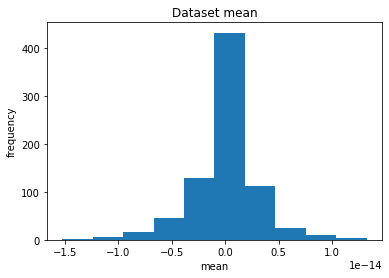

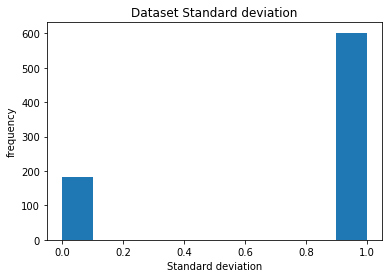

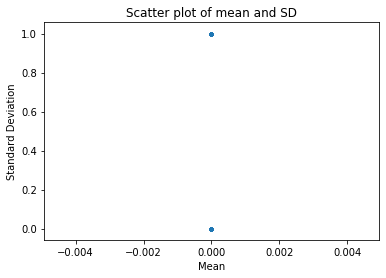

############# Test data #######
######Step1: standardize test data########
Name of class 1:7	Size of class 1:420
Name of class 2:8	Size of class 2:422
Name of class 3:9	Size of class 3:420
	Size of dataset:1262
number of features in dataset:  784


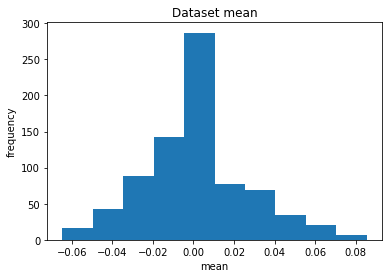

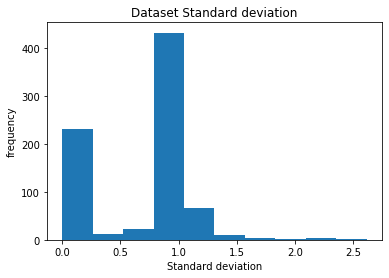

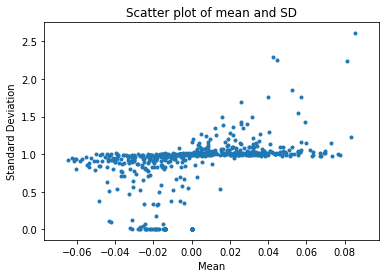

###########Step2 : delete zero columns#########
#describe train and test data after preprocessing
Name of class 1:7	Size of class 1:1677
Name of class 2:8	Size of class 2:1685
Name of class 3:9	Size of class 3:1680
	Size of dataset:5042
number of features in dataset:  602


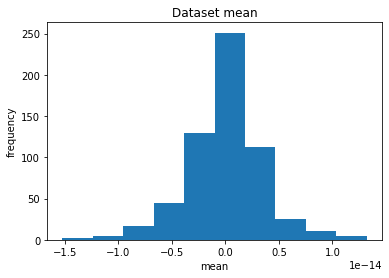

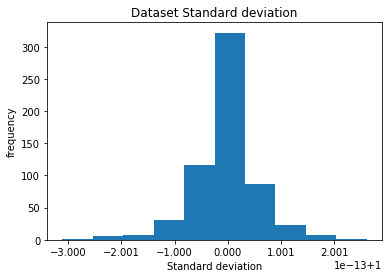

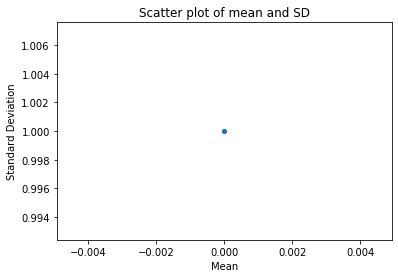

Name of class 1:7	Size of class 1:420
Name of class 2:8	Size of class 2:422
Name of class 3:9	Size of class 3:420
	Size of dataset:1262
number of features in dataset:  606


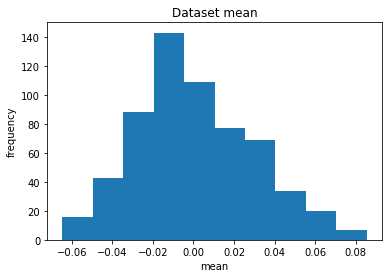

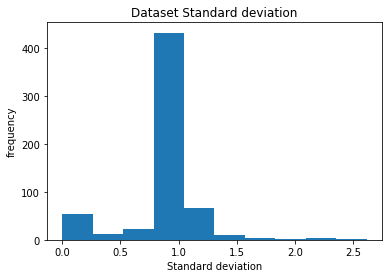

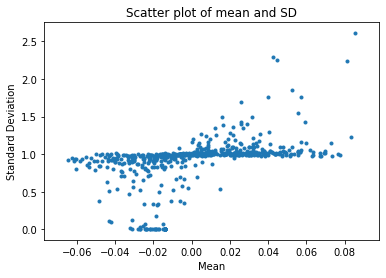

In [0]:
######PRE PROCESSING DATA################
# Fill missing elements
df_totaldata.fillna(0,inplace=True)
#describe total data 
print('############## Total data #######')
#dataset_describe(df_totaldata.drop(['label'],axis=1),df_totaldata['label'])

#create train and test datasets
prop = 80
train_data,test_data,train_data_nolabel,train_labels_all,test_data_nolabel,test_labels_all = create_traintestdata(prop,df_totaldata)

#describe trian and test data
print('############# Train data #######')
#dataset_describe(train_data_nolabel,train_labels_all)

train_data_nolabel.to_excel('train_data_nolabel.xlsx')



#preprocessing for Train set
######Step1: standardize train data########
df_train_mean = train_data_nolabel.mean()
df_train_std = train_data_nolabel.std()
df_train_std = np.where(df_train_std == 0,1,df_train_std)

train_data_nolabel = (train_data_nolabel - df_train_mean)/df_train_std
train_data_nolabel.fillna(0,inplace=True)
dataset_describe(train_data_nolabel,train_labels_all)

###########Step2 : delete zero columns#########
train_data_nolabel = remove_zerocolumns(train_data_nolabel.copy())


print('############# Test data #######')
#dataset_describe(test_data_nolabel,test_labels_all)
#preprocessing for Test set
print('######Step1: standardize test data########')
test_data_nolabel = (test_data_nolabel - df_train_mean)/df_train_std
test_data_nolabel.fillna(0,inplace=True)

dataset_describe(test_data_nolabel,test_labels_all)
print('###########Step2 : delete zero columns#########')
test_data_nolabel = remove_zerocolumns(test_data_nolabel.copy())

print('#describe train and test data after preprocessing')
dataset_describe(train_data_nolabel,train_labels_all)
dataset_describe(test_data_nolabel,test_labels_all)

#write to excel dataset
filepath = 'preprocessed_data.xlsx'

# with ExcelWriter(filepath) as writer:
#     train_data.to_excel(writer,sheet_name = 'train_data' )
#     test_data.to_excel(writer,sheet_name = 'test_data' )
#     train_data_nolabel.to_excel(writer,sheet_name = 'train_data_nolabel' )
#     train_labels_all.to_excel(writer,sheet_name = 'train_labels_all' )
#     test_data_nolabel.to_excel(writer,sheet_name = 'test_data_nolabel' )
#     test_labels_all.to_excel(writer,sheet_name = 'test_labels_all' )
#     writer.save()  

# 2.8.for original discrete features which you kept in RDS:
# compute and display the histograms of these values within each class

# PCA call

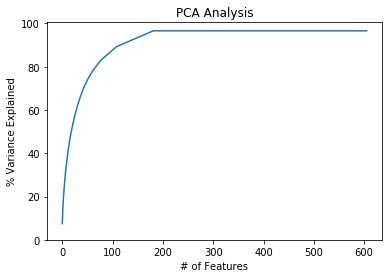

In [0]:
#Create a Covariance Matrix
#train
# covar_matrix = PCA(n_components = 599)
# covar_matrix.fit(train_data_nolabel)

#test data
covar_matrix = PCA(n_components = 606)
covar_matrix.fit(test_data_nolabel)

variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios


var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(0,100.5)
plt.style.context('seaborn-whitegrid')


plt.plot(var)

--------PCA Train data--------
explained_variance_ratio : 0.6551393285446255
Name of class 1:7	Size of class 1:1677
Name of class 2:8	Size of class 2:1685
Name of class 3:9	Size of class 3:1680
	Size of dataset:5042
number of features in dataset:  50


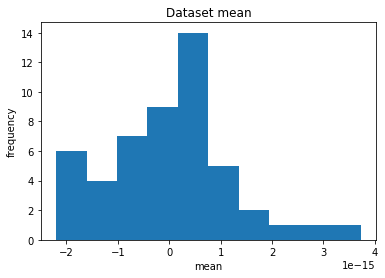

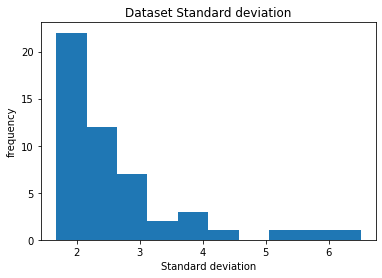

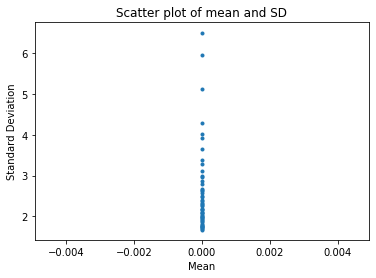

--------PCA Test data--------
explained_variance_ratio : 0.7353553637537766
Name of class 1:7	Size of class 1:420
Name of class 2:8	Size of class 2:422
Name of class 3:9	Size of class 3:420
	Size of dataset:1262
number of features in dataset:  50


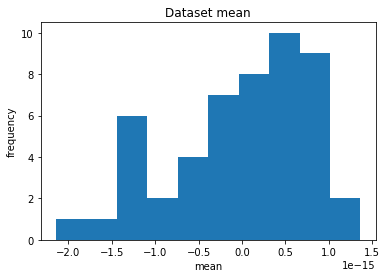

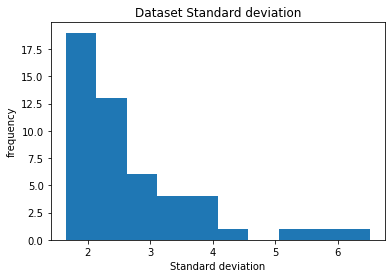

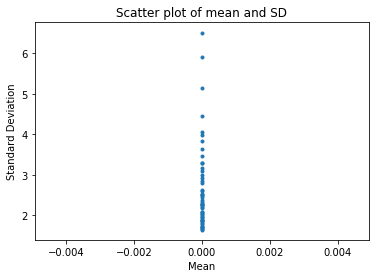

In [0]:
pca = PCA(n_components=50)
#fit train data
print("--------PCA Train data--------")
train_data_reduced = pca.fit_transform(train_data_nolabel)  
train_data_reduced = pd.DataFrame(train_data_reduced)
print('explained_variance_ratio :', np.sum(pca.explained_variance_ratio_) )
dataset_describe(train_data_reduced,train_labels_all)

#fit test data
print("--------PCA Test data--------")
test_data_reduced = pca.fit_transform(test_data_nolabel)  
test_data_reduced = pd.DataFrame(test_data_reduced)
print('explained_variance_ratio :', np.sum(pca.explained_variance_ratio_)) 
dataset_describe(test_data_reduced,test_labels_all)

#write to excel
filepath = 'reduced_data.xlsx'
with ExcelWriter(filepath) as writer:
    train_data_reduced.to_excel(writer,sheet_name = 'train_data_reduced' )
    train_labels_all.to_excel(writer,sheet_name = 'train_labels_all' )
    test_data_reduced.to_excel(writer,sheet_name = 'test_data_reduced' )
    test_labels_all.to_excel(writer,sheet_name = 'test_labels_all' )
    writer.save()  

# Step 2: Re-evaluation of tuning :



# 2.1 Pick another two classes CL1 vs CL3 for instance and re-launch the tuning as above to see which pair of parameters {gamma, cost} are selected

In [0]:
# tuning svm for reduced train dataset for class1 and class2
class1 = class_1
class2 = class_2

train_data,train_labels = create_twoclass_dataset(train_data_reduced,train_labels_all,class1,class2)

C_range = np.logspace(-2, 2, 5)
gamma_range = np.logspace(-2, 2, 5)

tuned_parameters = {'kernel': ['rbf'], 'C': C_range, 'gamma': gamma_range}
nfolds = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
is_test = False

best_params = tune(tuned_parameters,nfolds,is_test,train_data,train_labels)



In [0]:
print('C_range: ',C_range)
print('gamma_range: ',gamma_range)

C_range:  [1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]
gamma_range:  [1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]


creating dataset with 2 given classes:7,9 
train_data size1:  1677
train_data size total:  3357
train_labels_1 class:
 1677
self.train_labels total:
 3357
kernel_type :  rbf
------Fitting train data into svm model-----
# Tuning hyper-parameters


Best parameters set found on development set:

{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}

Grid scores on development set:

in heatmap: rbf


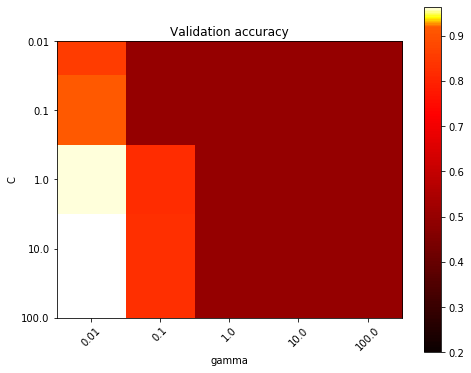

In [0]:
# tuning svm for reduced train dataset for class1 and class3
class1 = class_1
class2 = class_3
train_data,train_labels = create_twoclass_dataset(train_data_reduced,train_labels_all,class1,class2)

C_range = np.logspace(-2, 2, 5)
gamma_range = np.logspace(-2, 2, 5)

tuned_parameters = {'kernel': ['rbf'], 'C': C_range, 'gamma': gamma_range}
nfolds = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
is_test = False


best_params = tune(tuned_parameters,nfolds,is_test,train_data,train_labels)

# 2.2 Fix your own best parameters gamma and cost based on questions 1 & 2

In [0]:
best_params = {'kernel': ['rbf'], 'C': 10,'gamma' : 0.01}

# Question 3 : for the largest 3 classes CL1 CL2 CL3 , compute 3 SVMs
Use the best parameters previously identified to train 3 svms :
SVM1 to classify CL1 vs (not CL1)
SVM2 to classify CL2 vs (not CL2)
SVM3 to classify CL3 vs (not CL3)

data size1:  1677
data_labels_1 class:
 1677
size_sample:  838
data size total:  3353
data_labels total:
 3353
data size1:  420
data_labels_1 class:
 420
size_sample:  210
data size total:  840
data_labels total:
 840
kernel_type:  rbf
------Fitting train data into svm model-----
Score for above parameters in SVC model :  1.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:651: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


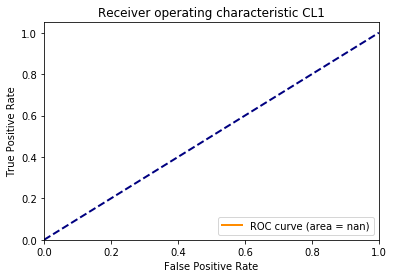

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


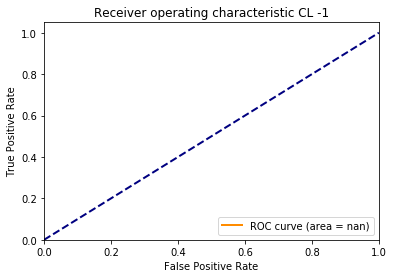

Number of Support vectors,S :  1355
Ratio of Support vectors,s :  0.4
unique:  [-1.  1.]
Confusion matrix, without normalization
[[1677    0]
 [   0 1676]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
confusion_matrix:
            pred_CL1  pred_CL_1
true_CL1       1677          0
true_CL_1         0       1676
confusion_matrix_norm:
            pred_CL1  pred_CL_1
true_CL1      100.0        0.0
true_CL_1       0.0      100.0

confmat_train_error:
            pred_CL1  pred_CL_1
true_CL1        0.0        0.0
true_CL_1       0.0        0.0 
confmat_train_confint:
                     pred_CL1          pred_CL_1
true_CL1   b'[100.0, 100.0]'      b'[0.0, 0.0]'
true_CL_1      b'[0.0, 0.0]'  b'[100.0, 100.0]'
------SVM applied on test set-----
Score for above parameters in SVC model for testset :  0.7440476190476191


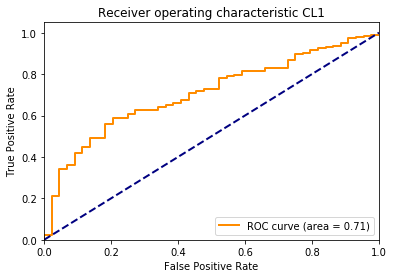

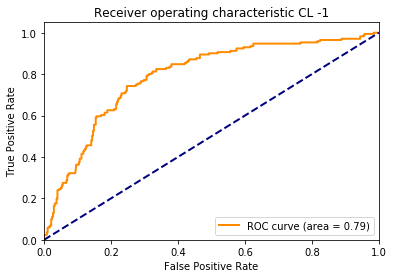

unique:  [-1.  1.]
Confusion matrix, without normalization
[[249 171]
 [ 44 376]]
Normalized confusion matrix
[[0.59285714 0.40714286]
 [0.1047619  0.8952381 ]]
confusion_matrix:
            pred_CL1  pred_CL_1
true_CL1        249        171
true_CL_1        44        376
confusion_matrix_norm:
            pred_CL1  pred_CL_1
true_CL1       59.0       41.0
true_CL_1      10.0       90.0

confmat_test_error:
            pred_CL1  pred_CL_1
true_CL1        2.0        2.0
true_CL_1       1.0        1.0 
confmat_test_confint:
                   pred_CL1        pred_CL_1
true_CL1   b'[55.0, 63.0]'  b'[37.0, 45.0]'
true_CL_1   b'[8.0, 12.0]'  b'[88.0, 92.0]'


In [0]:

#svm for class 1 vs (not class 1)
class_r =class_1
do_reduce = True

train_data,train_labels = create_data_cl_r(class_r,train_data_reduced,train_labels_all,do_reduce)
test_data,test_labels = create_data_cl_r(class_r,test_data_reduced,test_labels_all,do_reduce)

# filepath = 'SVM1_input.xlsx'
# with ExcelWriter(filepath) as writer:
#     pd.DataFrame(train_data).to_excel(writer,sheet_name = 'train_data' )
#     pd.DataFrame(train_labels).to_excel(writer,sheet_name = 'train_labels' )
#     pd.DataFrame(test_data).to_excel(writer,sheet_name = 'test_data' )
#     pd.DataFrame(test_labels).to_excel(writer,sheet_name = 'test_labels' )
#     writer.save() 


#creating dicitionary for parameters
#Build Radial kernel SVM with arbitrary cost and gamma
parameters =best_params
kernel_type = parameters['kernel'][0]



svm_1,confmat_train_1 = svm_call(kernel_type,parameters,train_data,train_labels,test_data,test_labels)


data size1:  1685
data_labels_1 class:
 1685
size_sample:  842
data size total:  3369
data_labels total:
 3369
data size1:  422
data_labels_1 class:
 422
size_sample:  211
data size total:  844
data_labels total:
 844
kernel_type:  rbf
------Fitting train data into svm model-----
Score for above parameters in SVC model :  1.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:651: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


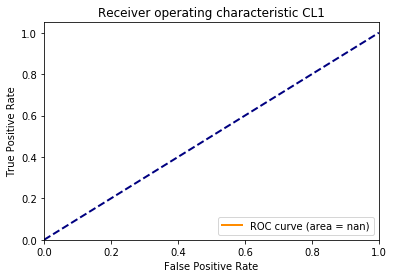

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


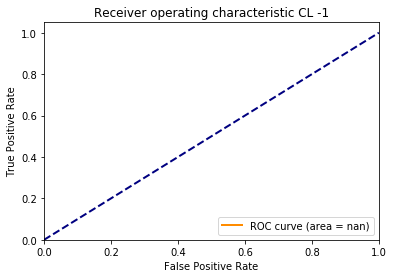

Number of Support vectors,S :  1305
Ratio of Support vectors,s :  0.39
unique:  [-1.  1.]
Confusion matrix, without normalization
[[1685    0]
 [   0 1684]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
confusion_matrix:
            pred_CL1  pred_CL_1
true_CL1       1685          0
true_CL_1         0       1684
confusion_matrix_norm:
            pred_CL1  pred_CL_1
true_CL1      100.0        0.0
true_CL_1       0.0      100.0

confmat_train_error:
            pred_CL1  pred_CL_1
true_CL1        0.0        0.0
true_CL_1       0.0        0.0 
confmat_train_confint:
                     pred_CL1          pred_CL_1
true_CL1   b'[100.0, 100.0]'      b'[0.0, 0.0]'
true_CL_1      b'[0.0, 0.0]'  b'[100.0, 100.0]'
------SVM applied on test set-----
Score for above parameters in SVC model for testset :  0.8436018957345972


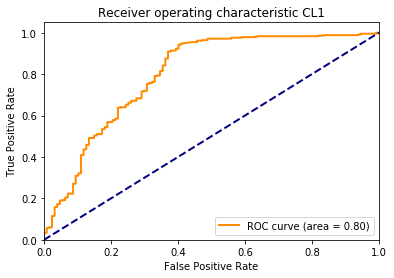

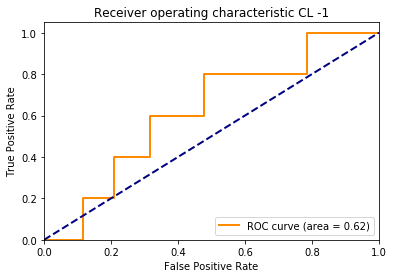

unique:  [-1.  1.]
Confusion matrix, without normalization
[[417   5]
 [127 295]]
Normalized confusion matrix
[[0.98815166 0.01184834]
 [0.30094787 0.69905213]]
confusion_matrix:
            pred_CL1  pred_CL_1
true_CL1        417          5
true_CL_1       127        295
confusion_matrix_norm:
            pred_CL1  pred_CL_1
true_CL1       99.0        1.0
true_CL_1      30.0       70.0

confmat_test_error:
            pred_CL1  pred_CL_1
true_CL1        0.0        0.0
true_CL_1       2.0        2.0 
confmat_test_confint:
                   pred_CL1        pred_CL_1
true_CL1   b'[99.0, 99.0]'    b'[1.0, 1.0]'
true_CL_1  b'[26.0, 34.0]'  b'[66.0, 74.0]'


In [0]:
#svm for class 2 vs (not class 2)
class_r =class_2
do_reduce = True
train_data,train_labels = create_data_cl_r(class_r,train_data_reduced,train_labels_all,do_reduce)
test_data,test_labels = create_data_cl_r(class_r,test_data_reduced,test_labels_all,do_reduce)

#creating dicitionary for parameters
#Build Radial kernel SVM with arbitrary cost and gamma
parameters =best_params
kernel_type = parameters['kernel'][0]

svm_2,confmat_train_2 = svm_call(kernel_type,parameters,train_data,train_labels,test_data,test_labels)

data size1:  1680
data_labels_1 class:
 1680
size_sample:  840
data size total:  3360
data_labels total:
 3360
data size1:  420
data_labels_1 class:
 420
size_sample:  210
data size total:  840
data_labels total:
 840
kernel_type:  rbf
------Fitting train data into svm model-----
Score for above parameters in SVC model :  1.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:651: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


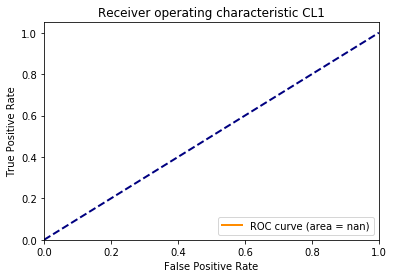

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


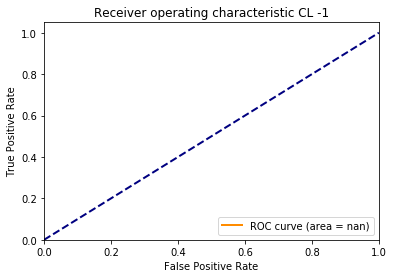

Number of Support vectors,S :  1324
Ratio of Support vectors,s :  0.39
unique:  [-1.  1.]
Confusion matrix, without normalization
[[1680    0]
 [   0 1680]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
confusion_matrix:
            pred_CL1  pred_CL_1
true_CL1       1680          0
true_CL_1         0       1680
confusion_matrix_norm:
            pred_CL1  pred_CL_1
true_CL1      100.0        0.0
true_CL_1       0.0      100.0

confmat_train_error:
            pred_CL1  pred_CL_1
true_CL1        0.0        0.0
true_CL_1       0.0        0.0 
confmat_train_confint:
                     pred_CL1          pred_CL_1
true_CL1   b'[100.0, 100.0]'      b'[0.0, 0.0]'
true_CL_1      b'[0.0, 0.0]'  b'[100.0, 100.0]'
------SVM applied on test set-----
Score for above parameters in SVC model for testset :  0.6142857142857143


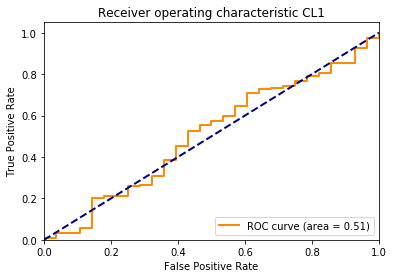

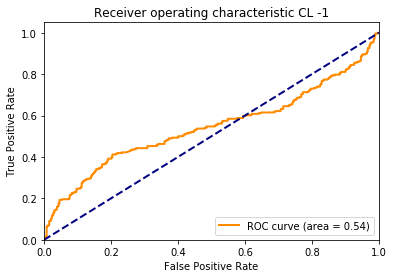

unique:  [-1.  1.]
Confusion matrix, without normalization
[[124 296]
 [ 28 392]]
Normalized confusion matrix
[[0.2952381  0.7047619 ]
 [0.06666667 0.93333333]]
confusion_matrix:
            pred_CL1  pred_CL_1
true_CL1        124        296
true_CL_1        28        392
confusion_matrix_norm:
            pred_CL1  pred_CL_1
true_CL1       30.0       70.0
true_CL_1       7.0       93.0

confmat_test_error:
            pred_CL1  pred_CL_1
true_CL1        2.0        2.0
true_CL_1       1.0        1.0 
confmat_test_confint:
                   pred_CL1        pred_CL_1
true_CL1   b'[26.0, 34.0]'  b'[66.0, 74.0]'
true_CL_1    b'[5.0, 9.0]'  b'[91.0, 95.0]'


In [0]:
#svm for class 3 vs (not class 3)
class_r =class_3
do_reduce = True

train_data,train_labels = create_data_cl_r(class_r,train_data_reduced,train_labels_all,do_reduce)
test_data,test_labels = create_data_cl_r(class_r,test_data_reduced,test_labels_all,do_reduce)

#creating dicitionary for parameters
#Build Radial kernel SVM with arbitrary cost and gamma
parameters = best_params
kernel_type = parameters['kernel'][0]

svm_3,confmat_train_3 = svm_call(kernel_type,parameters,train_data,train_labels,test_data,test_labels)

# Question 4 : for the largest 3 classes CL1 CL2 CL3 , combine the three SVMs to classify all cases

# 4.1 describe precisely for each new case x in Rp , how you can combine the three
classifications of x provided by SVM1 SVM2 SVM3 , taking account of their confusion matrices, in order
to obtain a terminal classification of x into one of the 3 classes CL1 CL2 CL3

In [0]:
print('confmat_train_1:\n',confmat_train_1)
print('confmat_train_2:\n',confmat_train_2)
print('confmat_train_3:\n',confmat_train_3)

confmat_train_1:
            pred_CL1  pred_CL_1
true_CL1      100.0        0.0
true_CL_1       0.0      100.0
confmat_train_2:
            pred_CL1  pred_CL_1
true_CL1      100.0        0.0
true_CL_1       0.0      100.0
confmat_train_3:
            pred_CL1  pred_CL_1
true_CL1      100.0        0.0
true_CL_1       0.0      100.0


In [0]:
#assigning values to composite confusion matrix
a11 = confmat_train_1.loc['true_CL1','pred_CL1']
a22 = confmat_train_1.loc['true_CL_1','pred_CL_1']
b11 = confmat_train_2.loc['true_CL1','pred_CL1']
b22 = confmat_train_2.loc['true_CL_1','pred_CL_1']
c11 = confmat_train_3.loc['true_CL1','pred_CL1']
c22 = confmat_train_3.loc['true_CL_1','pred_CL_1']
index_comp_CM = ['svm1','svm2','svm3']
data_comp_CM = {'class_1':np.around([a11,b22/2,c22/2]),
                   'class_2':np.around([a22/2,b11,c22/2]),
                   'class_3':np.around([a22/2,b22/2,c11])}


df_decision_CM = pd.DataFrame(data_comp_CM,index = index_comp_CM)/100
sum_comp_CM = np.sum(np.sum(df_decision_CM))
df_decision_CM



,class_1,class_2,class_3
svm1,1.0,0.5,0.5
svm2,0.5,1.0,0.5
svm3,0.5,0.5,1.0


# 4.2 Implement and run this combined classification on all x in CL1 CL2 CL3 which belong to TRAIN

In [0]:
pred_train_labels = predict_final(train_data_reduced,train_labels_all,svm_1,svm_2,svm_3)


unique:  [7 8 9]
Confusion matrix, without normalization
[[1677    0    0]
 [   2 1683    0]
 [  20   47 1613]]
Normalized confusion matrix
[[1.         0.         0.        ]
 [0.00118694 0.99881306 0.        ]
 [0.01190476 0.02797619 0.96011905]]
confusion_matrix:
           pred_CL1  pred_CL2  pred_CL3
true_CL1      1677         0         0
true_CL2         2      1683         0
true_CL3        20        47      1613
confusion_matrix with normalization:
           pred_CL1  pred_CL2  pred_CL3
true_CL1    100.00      0.00      0.00
true_CL2      0.12     99.88      0.00
true_CL3      1.19      2.80     96.01
confusion matrix error:
           pred_CL1  pred_CL2  pred_CL3
true_CL1       0.0       0.0       0.0
true_CL2       0.0       0.0       0.0
true_CL3       0.0       0.0       0.0
confusion matrix confidence intervals:
                    pred_CL1           pred_CL2         pred_CL3
true_CL1  b'[100.0, 100.0]'      b'[0.0, 0.0]'    b'[0.0, 0.0]'
true_CL2      b'[0.0, 0.0]'  b'[1

# TEMP practice

In [0]:



y_true = test_labels_all
y_pred = pred_test_labels
class_names = y_true
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [0]:
pred1 = np.array([1,-1])
print(pred1)
#expanding 1 column redictions to 3 column matrix 
matr11 = np.asmatrix(pred1).T
matr21 = np.repeat(matr11,3,axis=1)

#masking 3 column array to binary rows
matr21 = np.where(matr21>0,[1,0,0],[0,1,1])
print(matr21)
#multiplying wiht decision matrix corresponding row with svm result
mat_decision_CM = np.matrix(df_decision_CM)
result1 = matr21*np.array(mat_decision_CM[0])
print(result1)

In [0]:
pred2 = np.array([-1,1])
print(pred2)
matr12 = np.asmatrix(pred2).T
matr22 = np.repeat(matr12,3,axis=1)

#masking 3 column array to binary rows
matr22 = np.where(matr22>0,[0,1,0],[1,0,1])
print(matr22)
#multiplying wiht decision matrix corresponding row with svm result
mat_decision_CM = np.matrix(df_decision_CM)
result2 = matr22*np.array(mat_decision_CM[1])
print(result2)

In [0]:
pred3 = np.array([-1,1])
print(pred3)
matr13 = np.asmatrix(pred3).T
matr23 = np.repeat(matr13,3,axis=1)

#masking 3 column array to binary rows
matr23 = np.where(matr23>0,[0,0,1],[1,1,0])
print(matr23)
#multiplying wiht decision matrix corresponding row with svm result
mat_decision_CM = np.matrix(df_decision_CM)
result3 = matr23*np.array(mat_decision_CM[2])
print(result3)

In [0]:
result = result1+result2+result3
result

In [0]:
  #normalising by decision matrix sum
  sum_result_rows = np.sum(result,axis=1)
  print(sum_result_rows)
  result_norm = result/sum_result_rows[:,None]
  result_norm

In [0]:
#class with maximum coeficients
result_classes = np.argmax(result_norm,axis=1)+1
result_classes

In [0]:
result_classes == 1

In [0]:
train_predict1 = np.array([1,1,-1,-1])
matr1 = np.asmatrix(train_predict1).T
matr2 = np.repeat(matr1,3,axis=1)
matr2 = np.where(matr2>0,[1,0,0],[0,1,1])
matr2

In [0]:
train_predict1 = np.array([-1,1,1,-1])
matr3 = np.asmatrix(train_predict1).T
matr4 = np.repeat(matr3,3,axis=1)

matr4 = np.where(matr4>0,[1,0,0],[0,1,1])
matr4

array([[0, 1, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 1]])

In [0]:
mat_decision_CM = np.matrix(df_decision_CM)
matr2*np.array(mat_decision_CM[0])

array([[1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 0.5, 0.5]])

# 4.3.Do the same operation on all x in CL1 CL2 CL3 which belong to TEST

In [0]:
pred_test_labels = predict_final(test_data_reduced,test_labels_all,svm_1,svm_2,svm_3)


unique:  [7 8 9]
Confusion matrix, without normalization
[[289  97  34]
 [  4 417   1]
 [183 120 117]]
Normalized confusion matrix
[[0.68809524 0.23095238 0.08095238]
 [0.00947867 0.98815166 0.00236967]
 [0.43571429 0.28571429 0.27857143]]
confusion_matrix:
           pred_CL1  pred_CL2  pred_CL3
true_CL1       289        97        34
true_CL2         4       417         1
true_CL3       183       120       117
confusion_matrix with normalization:
           pred_CL1  pred_CL2  pred_CL3
true_CL1     68.81     23.10      8.10
true_CL2      0.95     98.82      0.24
true_CL3     43.57     28.57     27.86
confusion matrix error:
           pred_CL1  pred_CL2  pred_CL3
true_CL1       2.0       2.0       1.0
true_CL2       0.0       1.0       0.0
true_CL3       2.0       2.0       2.0
confusion matrix confidence intervals:
                  pred_CL1         pred_CL2         pred_CL3
true_CL1  b'[65.0, 73.0]'  b'[19.0, 27.0]'   b'[6.0, 10.0]'
true_CL2    b'[1.0, 1.0]'   b'[97.0, 100]'    b'[0

#4.4 Compute the associated two confusion matrices (which will be 3x3 matrices) and compare them

# 5.Repeat the whole preceding procedure using the polynomial kernel (K(x,y) = (1+<x,y>)2 .
There will be only one parameter to estimate by tuning, namely the Cost parameter. Compare the final
performance results to the approach using radial kernels

In [0]:
C_range

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

creating dataset with 2 given classes:7,8 
train_data size1:  1677
train_data size total:  3362
train_labels_1 class:
 1677
self.train_labels total:
 3362
kernel_type :  poly
------Fitting train data into svm model-----
# Tuning hyper-parameters


Best parameters set found on development set:

{'C': 0.01, 'coef0': 1, 'degree': 4, 'gamma': 1, 'kernel': 'poly'}

Grid scores on development set:

in heatmap: poly


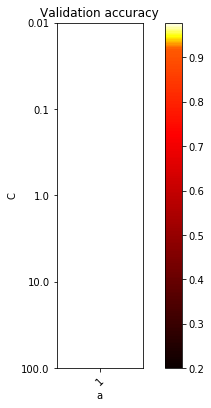

In [0]:
# tuning svm for reduced train dataset for class1 and class2
class1 = class_1
class2 = class_2

train_data,train_labels = create_twoclass_dataset(train_data_reduced,train_labels_all,class1,class2)

C_range = np.logspace(-2, 2, 5)
tuned_parameters = {'kernel': ['poly'], 'C': C_range, 'coef0' : [1],'gamma': [1],'degree':[4]}

nfolds = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
is_test = False

best_params = tune(tuned_parameters,nfolds,is_test,train_data,train_labels)



In [0]:
parameters ={'kernel': ['poly'], 'C': [0.01], 'coef0' : [1],'gamma': [1],'degree':[2]}
kernel_type = parameters['kernel'][0]
print(kernel_type)
print(parameters['degree'])
print(parameters['coef0'])
print(parameters['gamma'])
print(parameters['C'])

poly
[2]
[1]
[1]
[0.01]


creating dataset with 2 given classes:7,8 
train_data size1:  1677
train_data size total:  3362
train_labels_1 class:
 1677
self.train_labels total:
 3362
creating dataset with 2 given classes:7,8 
train_data size1:  420
train_data size total:  842
train_labels_1 class:
 420
self.train_labels total:
 842
kernel_type:  poly
------Fitting train data into svm model-----
Score for above parameters in SVC model :  1.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:651: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


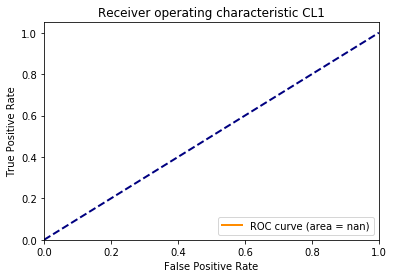

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


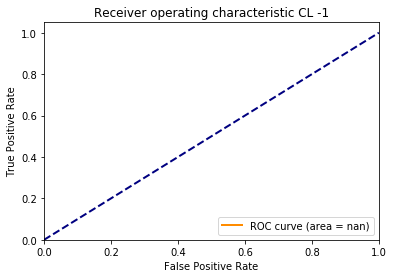

Number of Support vectors,S :  787
Ratio of Support vectors,s :  0.23
unique:  [-1.  1.]
Confusion matrix, without normalization
[[1677    0]
 [   0 1685]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
confusion_matrix:
            pred_CL1  pred_CL_1
true_CL1       1677          0
true_CL_1         0       1685
confusion_matrix_norm:
            pred_CL1  pred_CL_1
true_CL1      100.0        0.0
true_CL_1       0.0      100.0

confmat_train_error:
            pred_CL1  pred_CL_1
true_CL1        0.0        0.0
true_CL_1       0.0        0.0 
confmat_train_confint:
                     pred_CL1          pred_CL_1
true_CL1   b'[100.0, 100.0]'      b'[0.0, 0.0]'
true_CL_1      b'[0.0, 0.0]'  b'[100.0, 100.0]'
------SVM applied on test set-----
Score for above parameters in SVC model for testset :  0.5439429928741093


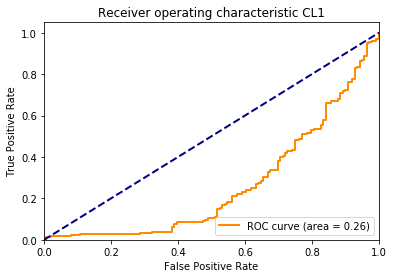

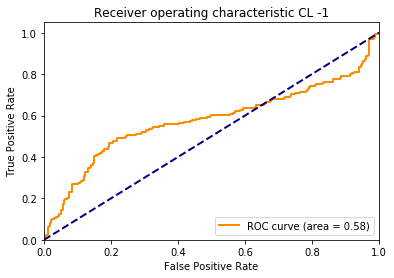

unique:  [-1.  1.]
Confusion matrix, without normalization
[[175 245]
 [139 283]]
Normalized confusion matrix
[[0.41666667 0.58333333]
 [0.32938389 0.67061611]]
confusion_matrix:
            pred_CL1  pred_CL_1
true_CL1        175        245
true_CL_1       139        283
confusion_matrix_norm:
            pred_CL1  pred_CL_1
true_CL1       42.0       58.0
true_CL_1      33.0       67.0

confmat_test_error:
            pred_CL1  pred_CL_1
true_CL1        2.0        2.0
true_CL_1       2.0        2.0 
confmat_test_confint:
                   pred_CL1        pred_CL_1
true_CL1   b'[38.0, 46.0]'  b'[54.0, 62.0]'
true_CL_1  b'[29.0, 37.0]'  b'[63.0, 71.0]'


In [0]:
#########sample check for sv ratio
#svm for class 1 vs class 3
class1 = class_1
class2 = class_2
do_reduce = True

train_data,train_labels = create_twoclass_dataset(train_data_reduced,train_labels_all,class1,class2)
test_data,test_labels = create_twoclass_dataset(test_data_reduced,test_labels_all,class1,class2)

#creating dicitionary for parameters
#Build Poly kernel SVM with arbitrary cost and gamma

parameters ={'kernel': ['poly'], 'C': 100, 'coef0' : 0.1,'gamma': 1,'degree':6}

kernel_type = parameters['kernel'][0]

svm_1,confmat_train_1 = svm_call(kernel_type,parameters,train_data,train_labels,test_data,test_labels)

creating dataset with 2 given classes:8,9 
train_data size1:  1685
train_data size total:  3365
train_labels_1 class:
 1685
self.train_labels total:
 3365
kernel_type :  poly
------Fitting train data into svm model-----
# Tuning hyper-parameters


Best parameters set found on development set:

{'C': 0.01, 'coef0': 1, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}

Grid scores on development set:

in heatmap: poly


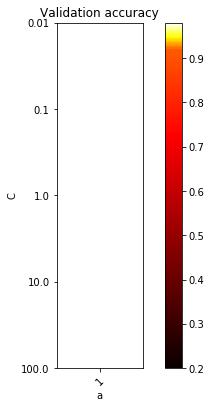

In [0]:
# tuning svm for reduced train dataset for class1 and class3
class1 = class_2
class2 = class_3
train_data,train_labels = create_twoclass_dataset(train_data_reduced,train_labels_all,class1,class2)

C_range = np.logspace(-2, 2, 5)

tuned_parameters = {'kernel': ['poly'], 'C': C_range, 'coef0' : [1],'gamma': [1],'degree':[2]}

nfolds = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
is_test = False

best_params = tune(tuned_parameters,nfolds,is_test,train_data,train_labels)

In [0]:
best_params = {'C': 0.01, 'coef0': 1, 'gamma': 1, 'kernel': ['poly'],'degree':2}

data size1:  1677
data_labels_1 class:
 1677
size_sample:  838
data size total:  3353
data_labels total:
 3353
data size1:  420
data_labels_1 class:
 420
size_sample:  210
data size total:  840
data_labels total:
 840
kernel_type:  poly
------Fitting train data into svm model-----
Score for above parameters in SVC model :  1.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:651: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


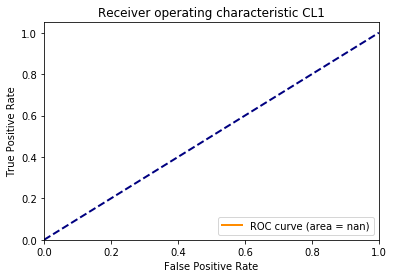

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


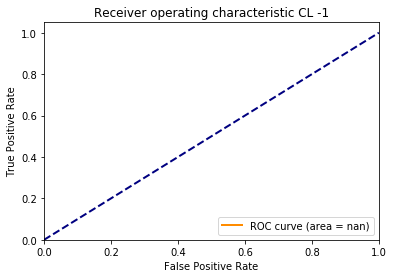

Number of Support vectors,S :  310
Ratio of Support vectors,s :  0.09
unique:  [-1.  1.]
Confusion matrix, without normalization
[[1677    0]
 [   0 1676]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
confusion_matrix:
            pred_CL1  pred_CL_1
true_CL1       1677          0
true_CL_1         0       1676
confusion_matrix_norm:
            pred_CL1  pred_CL_1
true_CL1      100.0        0.0
true_CL_1       0.0      100.0

confmat_train_error:
            pred_CL1  pred_CL_1
true_CL1        0.0        0.0
true_CL_1       0.0        0.0 
confmat_train_confint:
                     pred_CL1          pred_CL_1
true_CL1   b'[100.0, 100.0]'      b'[0.0, 0.0]'
true_CL_1      b'[0.0, 0.0]'  b'[100.0, 100.0]'
------SVM applied on test set-----
Score for above parameters in SVC model for testset :  0.5595238095238095


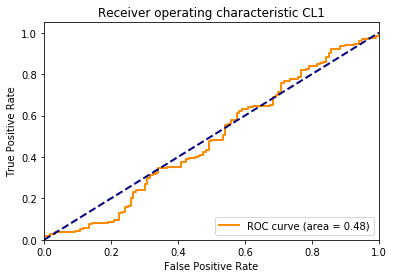

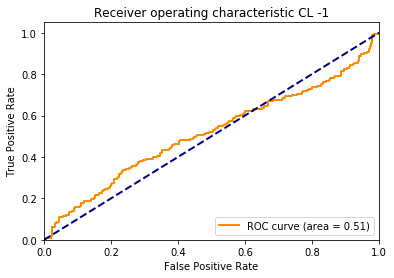

unique:  [-1.  1.]
Confusion matrix, without normalization
[[170 250]
 [120 300]]
Normalized confusion matrix
[[0.4047619  0.5952381 ]
 [0.28571429 0.71428571]]
confusion_matrix:
            pred_CL1  pred_CL_1
true_CL1        170        250
true_CL_1       120        300
confusion_matrix_norm:
            pred_CL1  pred_CL_1
true_CL1       40.0       60.0
true_CL_1      29.0       71.0

confmat_test_error:
            pred_CL1  pred_CL_1
true_CL1        2.0        2.0
true_CL_1       2.0        2.0 
confmat_test_confint:
                   pred_CL1        pred_CL_1
true_CL1   b'[36.0, 44.0]'  b'[56.0, 64.0]'
true_CL_1  b'[25.0, 33.0]'  b'[67.0, 75.0]'


In [0]:
#svm for class 1 vs (not class 1)
class_r =class_1
do_reduce = True

train_data,train_labels = create_data_cl_r(class_r,train_data_reduced,train_labels_all,do_reduce)
test_data,test_labels = create_data_cl_r(class_r,test_data_reduced,test_labels_all,do_reduce)

#creating dicitionary for parameters
#Build Poly kernel SVM with arbitrary cost and gamma
parameters =best_params
kernel_type = parameters['kernel'][0]

svm_1,confmat_train_1 = svm_call(kernel_type,parameters,train_data,train_labels,test_data,test_labels)


data size1:  1685
data_labels_1 class:
 1685
size_sample:  842
data size total:  3369
data_labels total:
 3369
data size1:  422
data_labels_1 class:
 422
size_sample:  211
data size total:  844
data_labels total:
 844
kernel_type:  poly
------Fitting train data into svm model-----
Score for above parameters in SVC model :  1.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:651: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


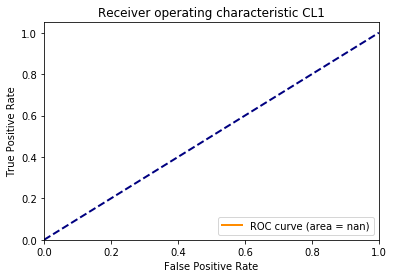

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


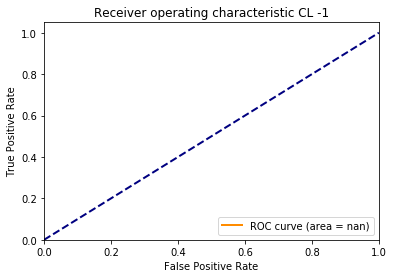

Number of Support vectors,S :  261
Ratio of Support vectors,s :  0.08
unique:  [-1.  1.]
Confusion matrix, without normalization
[[1685    0]
 [   0 1684]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
confusion_matrix:
            pred_CL1  pred_CL_1
true_CL1       1685          0
true_CL_1         0       1684
confusion_matrix_norm:
            pred_CL1  pred_CL_1
true_CL1      100.0        0.0
true_CL_1       0.0      100.0

confmat_train_error:
            pred_CL1  pred_CL_1
true_CL1        0.0        0.0
true_CL_1       0.0        0.0 
confmat_train_confint:
                     pred_CL1          pred_CL_1
true_CL1   b'[100.0, 100.0]'      b'[0.0, 0.0]'
true_CL_1      b'[0.0, 0.0]'  b'[100.0, 100.0]'
------SVM applied on test set-----
Score for above parameters in SVC model for testset :  0.6765402843601895


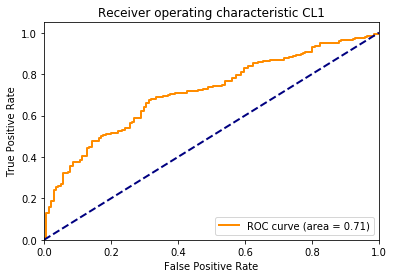

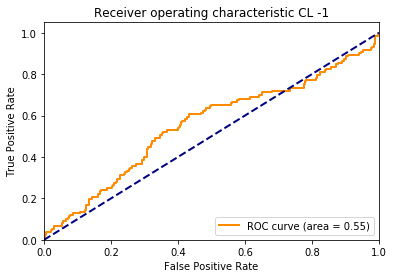

unique:  [-1.  1.]
Confusion matrix, without normalization
[[290 132]
 [141 281]]
Normalized confusion matrix
[[0.68720379 0.31279621]
 [0.33412322 0.66587678]]
confusion_matrix:
            pred_CL1  pred_CL_1
true_CL1        290        132
true_CL_1       141        281
confusion_matrix_norm:
            pred_CL1  pred_CL_1
true_CL1       69.0       31.0
true_CL_1      33.0       67.0

confmat_test_error:
            pred_CL1  pred_CL_1
true_CL1        2.0        2.0
true_CL_1       2.0        2.0 
confmat_test_confint:
                   pred_CL1        pred_CL_1
true_CL1   b'[65.0, 73.0]'  b'[27.0, 35.0]'
true_CL_1  b'[29.0, 37.0]'  b'[63.0, 71.0]'


In [0]:
#svm for class 2 vs (not class 2)
class_r =class_2
do_reduce = True
train_data,train_labels = create_data_cl_r(class_r,train_data_reduced,train_labels_all,do_reduce)
test_data,test_labels = create_data_cl_r(class_r,test_data_reduced,test_labels_all,do_reduce)

#creating dicitionary for parameters
#Build Radial kernel SVM with arbitrary cost and gamma
parameters =best_params
kernel_type = parameters['kernel'][0]

svm_2,confmat_train_2 = svm_call(kernel_type,parameters,train_data,train_labels,test_data,test_labels)

data size1:  1680
data_labels_1 class:
 1680
size_sample:  840
data size total:  3360
data_labels total:
 3360
data size1:  420
data_labels_1 class:
 420
size_sample:  210
data size total:  840
data_labels total:
 840
kernel_type:  poly
------Fitting train data into svm model-----
Score for above parameters in SVC model :  1.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:651: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


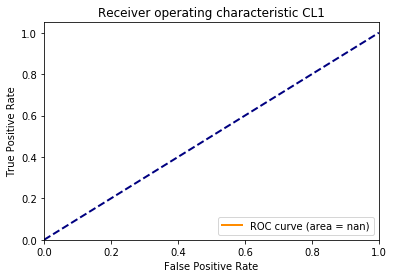

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


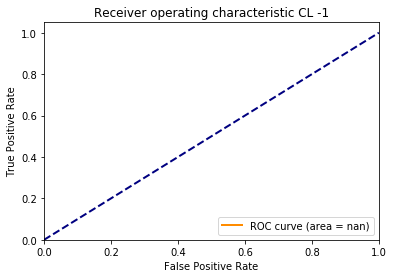

Number of Support vectors,S :  304
Ratio of Support vectors,s :  0.09
unique:  [-1.  1.]
Confusion matrix, without normalization
[[1680    0]
 [   0 1680]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
confusion_matrix:
            pred_CL1  pred_CL_1
true_CL1       1680          0
true_CL_1         0       1680
confusion_matrix_norm:
            pred_CL1  pred_CL_1
true_CL1      100.0        0.0
true_CL_1       0.0      100.0

confmat_train_error:
            pred_CL1  pred_CL_1
true_CL1        0.0        0.0
true_CL_1       0.0        0.0 
confmat_train_confint:
                     pred_CL1          pred_CL_1
true_CL1   b'[100.0, 100.0]'      b'[0.0, 0.0]'
true_CL_1      b'[0.0, 0.0]'  b'[100.0, 100.0]'
------SVM applied on test set-----
Score for above parameters in SVC model for testset :  0.725


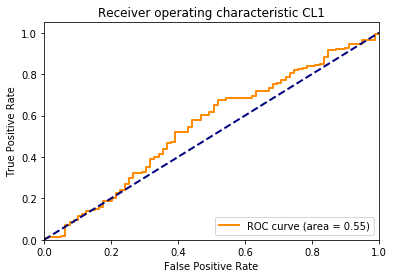

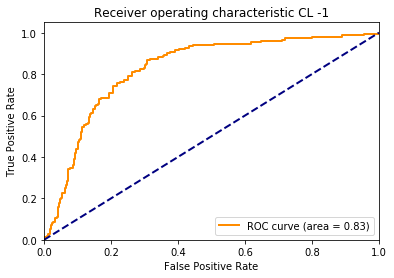

unique:  [-1.  1.]
Confusion matrix, without normalization
[[268 152]
 [ 79 341]]
Normalized confusion matrix
[[0.63809524 0.36190476]
 [0.18809524 0.81190476]]
confusion_matrix:
            pred_CL1  pred_CL_1
true_CL1        268        152
true_CL_1        79        341
confusion_matrix_norm:
            pred_CL1  pred_CL_1
true_CL1       64.0       36.0
true_CL_1      19.0       81.0

confmat_test_error:
            pred_CL1  pred_CL_1
true_CL1        2.0        2.0
true_CL_1       2.0        2.0 
confmat_test_confint:
                   pred_CL1        pred_CL_1
true_CL1   b'[60.0, 68.0]'  b'[32.0, 40.0]'
true_CL_1  b'[15.0, 23.0]'  b'[77.0, 85.0]'


In [0]:
#svm for class 3 vs (not class 3)
class_r =class_3
do_reduce = True

train_data,train_labels = create_data_cl_r(class_r,train_data_reduced,train_labels_all,do_reduce)
test_data,test_labels = create_data_cl_r(class_r,test_data_reduced,test_labels_all,do_reduce)

#creating dicitionary for parameters
#Build Radial kernel SVM with arbitrary cost and gamma
parameters = best_params
kernel_type = parameters['kernel'][0]

svm_3,confmat_train_3 = svm_call(kernel_type,parameters,train_data,train_labels,test_data,test_labels)

In [0]:
print('confmat_train_1:\n',confmat_train_1)
print('confmat_train_2:\n',confmat_train_2)
print('confmat_train_3:\n',confmat_train_3)

confmat_train_1:
            pred_CL1  pred_CL_1
true_CL1      100.0        0.0
true_CL_1       0.0      100.0
confmat_train_2:
            pred_CL1  pred_CL_1
true_CL1      100.0        0.0
true_CL_1       0.0      100.0
confmat_train_3:
            pred_CL1  pred_CL_1
true_CL1      100.0        0.0
true_CL_1       0.0      100.0


In [0]:
#assigning values to composite confusion matrix
a11 = confmat_train_1.loc['true_CL1','pred_CL1']
a22 = confmat_train_1.loc['true_CL_1','pred_CL_1']
b11 = confmat_train_2.loc['true_CL1','pred_CL1']
b22 = confmat_train_2.loc['true_CL_1','pred_CL_1']
c11 = confmat_train_3.loc['true_CL1','pred_CL1']
c22 = confmat_train_3.loc['true_CL_1','pred_CL_1']
index_comp_CM = ['svm1','svm2','svm3']
data_comp_CM = {'class_1':np.around([a11,b22/2,c22/2]),
                   'class_2':np.around([a22/2,b11,c22/2]),
                   'class_3':np.around([a22/2,b22/2,c11])}


df_decision_CM = pd.DataFrame(data_comp_CM,index = index_comp_CM)/100
sum_comp_CM = np.sum(np.sum(df_decision_CM))
df_decision_CM



,class_1,class_2,class_3
svm1,1.0,0.5,0.5
svm2,0.5,1.0,0.5
svm3,0.5,0.5,1.0


In [0]:
pred_train_labels = predict_final(train_data_reduced,train_labels_all,svm_1,svm_2,svm_3)


unique:  [7 8 9]
Confusion matrix, without normalization
[[1677    0    0]
 [  28 1657    0]
 [  49   17 1614]]
Normalized confusion matrix
[[1.         0.         0.        ]
 [0.01661721 0.98338279 0.        ]
 [0.02916667 0.01011905 0.96071429]]
confusion_matrix:
           pred_CL1  pred_CL2  pred_CL3
true_CL1      1677         0         0
true_CL2        28      1657         0
true_CL3        49        17      1614
confusion_matrix with normalization:
           pred_CL1  pred_CL2  pred_CL3
true_CL1    100.00      0.00      0.00
true_CL2      1.66     98.34      0.00
true_CL3      2.92      1.01     96.07
confusion matrix error:
           pred_CL1  pred_CL2  pred_CL3
true_CL1       0.0       0.0       0.0
true_CL2       0.0       0.0       0.0
true_CL3       0.0       0.0       0.0
confusion matrix confidence intervals:
                    pred_CL1         pred_CL2         pred_CL3
true_CL1  b'[100.0, 100.0]'    b'[0.0, 0.0]'    b'[0.0, 0.0]'
true_CL2      b'[2.0, 2.0]'  b'[98.0,

In [0]:
pred_test_labels = predict_final(test_data_reduced,test_labels_all,svm_1,svm_2,svm_3)


unique:  [7 8 9]
Confusion matrix, without normalization
[[251  94  75]
 [207 193  22]
 [105 121 194]]
Normalized confusion matrix
[[0.59761905 0.22380952 0.17857143]
 [0.49052133 0.45734597 0.0521327 ]
 [0.25       0.28809524 0.46190476]]
confusion_matrix:
           pred_CL1  pred_CL2  pred_CL3
true_CL1       251        94        75
true_CL2       207       193        22
true_CL3       105       121       194
confusion_matrix with normalization:
           pred_CL1  pred_CL2  pred_CL3
true_CL1     59.76     22.38     17.86
true_CL2     49.05     45.73      5.21
true_CL3     25.00     28.81     46.19
confusion matrix error:
           pred_CL1  pred_CL2  pred_CL3
true_CL1       2.0       2.0       2.0
true_CL2       2.0       2.0       1.0
true_CL3       2.0       2.0       2.0
confusion matrix confidence intervals:
                  pred_CL1         pred_CL2         pred_CL3
true_CL1  b'[56.0, 64.0]'  b'[18.0, 26.0]'  b'[14.0, 22.0]'
true_CL2  b'[45.0, 53.0]'  b'[42.0, 50.0]'    b'[3